In [1]:
import warnings
warnings.filterwarnings('ignore')
from numpy import array
from keras.models import Sequential
from keras.layers import RepeatVector, Dense, Flatten, LSTM, TimeDistributed, Dropout,Input, GRU
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import savgol_filter
import scipy.stats as stats
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy import fftpack

Using TensorFlow backend.


In [2]:
#main idea from:
#https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

In [3]:
def error_metric(real,forecast):
    mse_val = mean_squared_error(real,forecast)
    rmse_val = sqrt(mse_val)
    mae_val = mean_absolute_error(real,forecast)
    return(mse_val,rmse_val,mae_val)

In [4]:
def resample_1(serie_to_predict):
    
    for i in range(1):
        #print(i)
        dividendo = (serie_to_predict[i+1]-serie_to_predict[i])/int(len(serie_to_predict)-1)
        if dividendo == 0:
            x1=[serie_to_predict[i]]
            range_1 = np.repeat(x1,10)
        else:
            range_1 = np.arange(serie_to_predict[i], serie_to_predict[i+1], dividendo).tolist()
    hall = []
    for i in range(int(len(serie_to_predict)-2)):
        #print(i)
        dividendo = (serie_to_predict[i+2] - serie_to_predict[i+1])/int(len(serie_to_predict)-1)
        if dividendo == 0:
            x1=[serie_to_predict[i+1]]
            range_2 = np.repeat(x1,10)
        else:
            range_2 = np.arange(serie_to_predict[i+1], serie_to_predict[i+2], dividendo).tolist()
        hall.append(range_2)        
    flat_list = [item for sublist in hall for item in sublist]
    total = range_1 + flat_list
    total.append(serie_to_predict[-1])
    window = 11 
    total_1 = savgol_filter(total, window, 3) 
    return total_1

In [5]:
def forecasted(entrance, size_forecast, n_input, n_features, epochs, steps, L1, L2, drop_out):
    series = entrance[:-size_forecast]
    series = series.reshape((len(series), n_features))
    # define generator
    generator = TimeseriesGenerator(series, series, length=n_input, batch_size=8)
    model=Sequential()
    model.add(LSTM(L1,activation='relu',input_shape=(n_input, n_features),return_sequences=True)) 
    model.add(Dropout(drop_out))
    model.add(LSTM(L2,activation='relu'))
    model.add(Dense(1))
    #model.add(Dense(1, activation='relu'))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    #epochs=150
    #steps = 5 #10
    #history = model.fit_generator(generator, steps_per_epoch=1, epochs=epochs, verbose=0)
    history = model.fit_generator(generator, steps_per_epoch = steps, epochs=epochs, verbose=0)
    # Plot training & validation loss values
    fig, ax = plt.subplots(figsize=(5, 5), sharex=True)
    plt.plot(history.history["loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
    plt.legend(["Train", "Test"], loc="upper left")
    plt.grid()
    plt.show()
    # make a one step prediction out of sample
    #print(entrance[-size_forecast:])
    serie_input = entrance[-2*size_forecast:-size_forecast]
    #n_features = 1
    x_input = serie_input.reshape((1, n_input, n_features))
    #print(serie_input)
    yhat = model.predict(x_input, verbose=0)
    #print(yhat)
    list1 = yhat[0].tolist()
    answer = str(round(list1[0], 2))
    a_list = np.append(entrance[-int(size_forecast-1):], answer)
    x_input = a_list.reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=0)
    list1 = yhat[0].tolist()
    for i in range(int(size_forecast-(1))):
        list1 = yhat[0].tolist()
        answer = str(round(list1[0], 2))
        a_list = np.append(a_list[-int(size_forecast-1):], answer)
        x_input = a_list.reshape((1, n_input, n_features))
        yhat = model.predict(x_input, verbose=0)
        list1 = yhat[0].tolist()
    ausgang = []
    a1 = entrance[-int(size_forecast+1)]
    for i in range(int(size_forecast)):
        bond = float(a_list[i])
        ausgang.append(bond)
    ausgang.insert(0, entrance[-int(size_forecast+1)])
    #print(ausgang)
    return ausgang

In [6]:
#filename = "anomaly_data_1880_2020_goddard_150.csv"
#goddard_series = pd.read_csv(filename)
#goddard_series = goddard_series.dropna()['Goddard'] 
#goddard_series = goddard_series.values
#=============================================================
filename = "solar_irradiance_1880_2020.csv"
goddard_series = pd.read_csv(filename)
goddard_series = goddard_series.dropna()['Wm2'] 
goddard_series = goddard_series.values

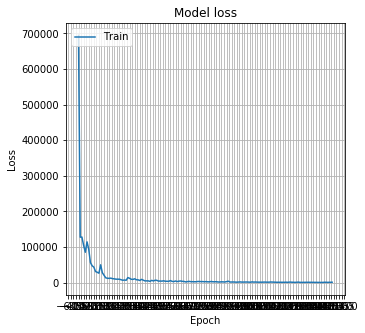

In [7]:
size_forecast = 10 # 10 para "anomaly_data_1880_2020_goddard_150.csv"
n_input = 10 # 10 para "anomaly_data_1880_2020_goddard_150.csv"
n_features = 1
epochs=150
steps = 20 #10
L1 = 150
L2 = 150
drop_out = 0.3
prediction_base = forecasted(goddard_series, size_forecast, n_input, n_features, epochs, steps, L1, L2, drop_out)

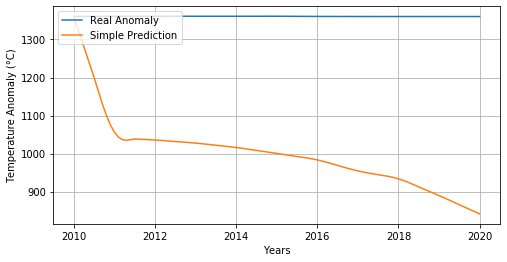

In [8]:
prediction_base_resampled = resample_1(prediction_base)
goddard_series_base = goddard_series[-int(size_forecast+1):].tolist()
real_anomaly_base_resampled = resample_1(goddard_series_base)
fig, ax = plt.subplots(figsize=(8,4))
e=list(range(len(real_anomaly_base_resampled)))
e = [x/10 for x in e]
e = [x + (2010) for x in e]
ax.plot(e, real_anomaly_base_resampled)
ax.plot(e, prediction_base_resampled)
ax.set_xlabel('Years')
ax.set_ylabel('Temperature Anomaly (°C)');
ax.legend(['Real Anomaly','Simple Prediction'], loc='upper left')
ax.grid()

In [9]:
#np.savetxt('anomaly_predicted_stacked_lstm.csv',prediction_resampled, delimiter=',', header=str('temperature'), comments="")